In [ ]:
from ctypes import c_double
import numpy as np
from decimal import Decimal
from scipy.stats import laplace
import scipy
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from math import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [ ]:
def table(data, name, k = 0, df1 = 0, df2 = 0):
    df = pd.DataFrame(columns=["left", "right", 'Ni', "Wi"])
    data.sort()
    m = round(1 + 3.332 * math.log10(1000))
    h = (max(data) - min(data))/m
    left = []
    right = []
    ni = []
    for i in range(m+1):
        a = np.count_nonzero((data >= min(data) + h*i ) & (data < min(data) + h*(i+1)))
        ni.append(a)

        b = min(data) + h*i
        left.append(b)

        c =  min(data) + h*(i+1)
        right.append(c)

    ni = np.array(ni)
    left = np.array(left)
    right = np.array(right)

    df['Ni'] = ni
    df['left'] = left
    df['right'] = right
    df['Wi'] = df['Ni'] / 1000

    if name == 'norm':
        cdf = scipy.stats.norm.cdf(df["right"], mean_x(data), std_x(data)) - scipy.stats.norm.cdf(df["left"], mean_x(data), std_x(data))
    if name == 'chi2':
        cdf = scipy.stats.chi2.cdf(df["right"], k) - scipy.stats.chi2.cdf(df["left"], k)
    if name == 'f':
        cdf = scipy.stats.f.cdf(df["right"], df1, df2) - scipy.stats.f.cdf(df["left"], df1,df2)
    if name == 't':
        cdf = scipy.stats.t.cdf(df["right"], k) - scipy.stats.t.cdf(df["left"], k)

    df["Pi"] = cdf
    df["Pn"] = df["Pi"]*1000
    df["H"] = (df['Ni'] - df["Pn"])**2/df["Pn"]
    df['Xi'] = (df['left'] + df['right'])/2
    return df

# **Нормальное**

In [ ]:
size = 1000 # количество элементов
k = 20 # реализаций
a = 0.94 # уровень доверия

f1 = [sum(np.random.uniform(low=-1.0, high=1.0, size=k)) for _ in range(size)]


In [ ]:
#рассчитать число групп
m = ceil(3.332 * log(len(f1), 10)) + 1
print("Число групп: ", m)

#вычислить значения границ
h = (max(f1) - min(f1)) / m
print("Длина интервала:", h)
x = [min(f1) - 0.01]
for i in range(m + 1):
  x.append(x[-1] + h)
print("Значения границ: ", x)

median = [] # середины интервалов
for i in range(len(x) - 1):
  median.append(sum(x[i:i+2]) / 2)
median = np.array(median)

#построить вариационный ряд
f1 = sorted(f1)
print("Вариационный ряд: ", f1)

#построить гистограмму
abs_freq = np.zeros(m + 1) # абсолютная частота
for i in f1:
  j = 0
  while i > x[j + 1]:
    j += 1
  abs_freq[j] += 1

rel_freq = abs_freq / len(f1) # относительная частота

# Добавить теоретические частоты scipy.stats.norm.cdf()
# подобрать 3 разных k
#повернуть x_labels

Число групп:  11
Длина интервала: 1.330738755845544
Значения границ:  [-7.698656708558256, -6.3679179527127125, -5.037179196867169, -3.706440441021625, -2.3757016851760815, -1.0449629293305376, 0.2857758265150063, 1.6165145823605502, 2.947253338206094, 4.277992094051638, 5.6087308498971815, 6.939469605742725, 8.270208361588269]
Вариационный ряд:  [-7.6886567085582564, -7.220311380869121, -6.496310956933975, -6.08753607507812, -6.031862925319068, -5.784109665784447, -5.645628114947719, -5.617832099947618, -5.585634933214779, -5.44014056764955, -5.375716429165578, -5.2935055707987395, -5.284593410380674, -5.238152481507316, -5.2093800994304535, -4.9942161236462175, -4.952606405260659, -4.9256239915516025, -4.904457986251679, -4.853280084442602, -4.8520616703125405, -4.803251059417532, -4.786697533698044, -4.784852864277027, -4.7360185342963605, -4.67303510895831, -4.649189494001152, -4.62907154054436, -4.622799676032849, -4.605243538684368, -4.5547506323505775, -4.55394627879165, -4.5501

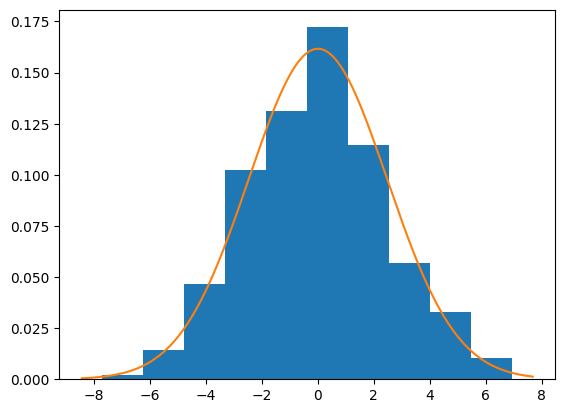

In [ ]:
plt.hist(f1, density = True)
xmin, xmax = plt.xlim()
ox = np.linspace(xmin, xmax, 1000)
plt.plot(ox, scipy.stats.norm.pdf(ox,np.mean(f1), np.std(f1)))

In [ ]:
x_v = []
for i in f1:
  h_i = 0
  while i < x[h_i]:
    h_i += 1
  x_v.append(i * abs_freq[h_i - 1])
x_v = np.sum(x_v) / len(f1) # выборочное среднее


s = np.std(f1)
p = []
for i in range(len(x) - 1):
  s1 = scipy.stats.norm.cdf(float((x[i + 1] - x_v) / s)) - 0.5
  s2 = scipy.stats.norm.cdf(float((x[i] - x_v) / s)) - 0.5
  p.append(s1 - s2)


abs_teor_freq = np.array(p) * len(f1)

# критическое значение
a = 0.05
k = m - 1 # число степеней свободы
ppf = scipy.stats.chi2.ppf(1-a, k - 2)

# критерий Пирсона
x_2 = sum((abs_freq - abs_teor_freq) ** 2 / abs_teor_freq)
print("Полученное значение критерия Пирсона:", x_2)
print("Критическое значение:", ppf)

print("Полученное значение критерия Пирсона меньше критического значения, поэтому гипотеза (норм. распределение) подтверждается")

Полученное значение критерия Пирсона: 11.282796407557111
Критическое значение: 15.50731305586545
Полученное значение критерия Пирсона меньше критического значения, поэтому гипотеза (норм. распределение) подтверждается


0.9902703738532328


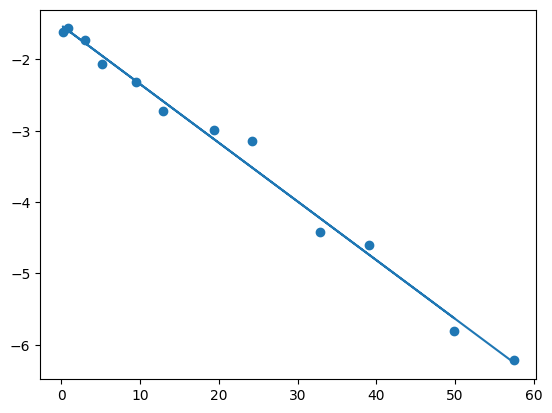

In [ ]:
y = np.log(rel_freq)
x_n = (median - x_v) ** 2
plt.scatter(x_n, y)


model = LinearRegression()
model.fit(x_n.reshape(-1, 1), y.reshape(-1, 1))
pred = model.predict(x_n.reshape(-1, 1))
plt.plot(x_n, pred)

print(r2_score(y, pred))

# figure(10, 10)

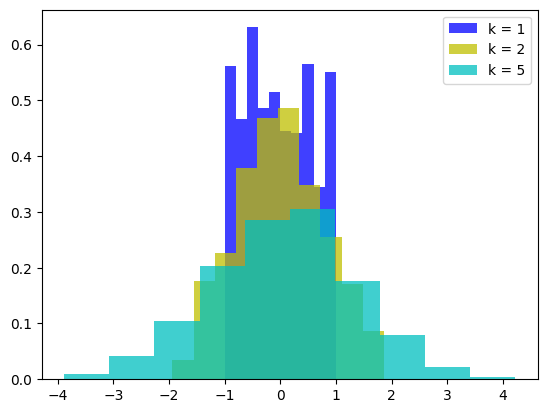

In [ ]:
data1 = [sum(np.random.uniform(low=-1.0, high=1.0, size=1)) for _ in range(size)]
data2 = [sum(np.random.uniform(low=-1.0, high=1.0, size=2)) for _ in range(size)]
data3 = [sum(np.random.uniform(low=-1.0, high=1.0, size=5)) for _ in range(size)]
plt.hist(data1, density = True, color = 'b', alpha=0.75)
plt.hist(data2, density = True, color = 'y',alpha=0.75)
plt.hist(data3, density = True, color = 'c',alpha=0.75)
plt.legend(['k = 1', 'k = 2', 'k = 5'])

# Хи-квадрат

In [ ]:
def chi2(n, k):
  l = [sum(np.random.uniform(low=-1.0, high=1.0, size=k)) for _ in range(1000)]
  l = np.array(l)
  z = (l - l.mean()) / l.std()
  y = z ** 2
  for _ in range(n - 1):
      l = [sum(np.random.uniform(low=-1.0, high=1.0, size=k)) for _ in range(1000)]
      l = np.array(l)
      z = (l - l.mean()) / l.std()
      y += z ** 2
  return y


f1 = chi2(1, 20)

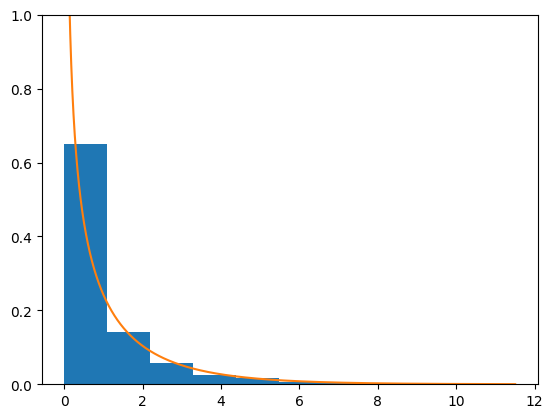

In [ ]:
plt.hist(f1, density = True)
plt.ylim(0, 1)
xmin, xmax = plt.xlim()
ox = np.arange(0, xmax, 0.001)
plt.plot(ox, scipy.stats.chi2.pdf(ox,df=1))

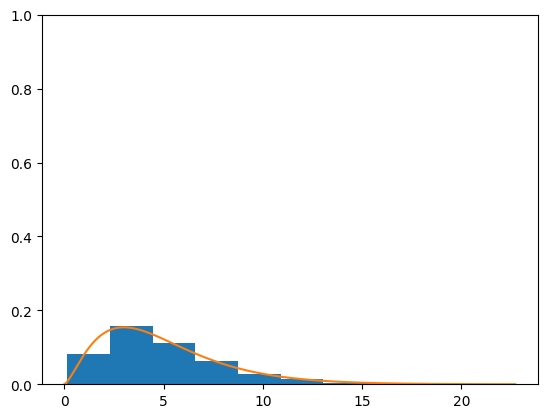

In [ ]:
f2 = chi2(5, 20)

plt.hist(f2, density = True)
plt.ylim(0, 1)
xmin, xmax = plt.xlim()
ox = np.arange(0, xmax, 0.001)
plt.plot(ox, scipy.stats.chi2.pdf(ox,df=5))

In [ ]:
df = table(f2, "chi2", k=5)

print("Критерий пирсона:", sum(df["H"]))
print("Критическое значение:", scipy.stats.chi2.ppf(1-0.05, 9))

Критерий пирсона: 9.509350908570905
Критическое значение: 16.918977604620448


# Фишера

In [ ]:
d1=5
d2=10
y1 = chi2(d1, 20)
y2 = chi2(d2, 20)
f1 = (y1 / d1) / (y2/d2)

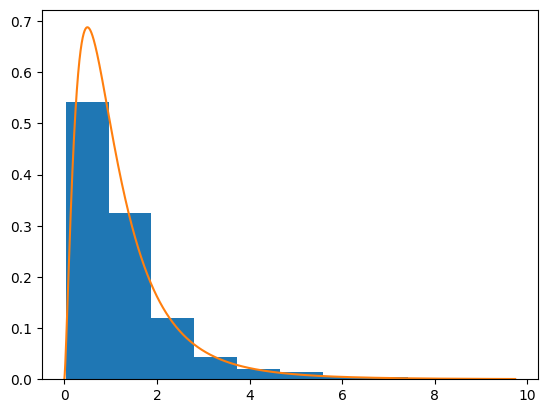

In [ ]:
plt.hist(f1, density = True)
xmin, xmax = plt.xlim()
ox = np.arange(0, xmax, 0.001)
plt.plot(ox, scipy.stats.f.pdf(ox,d1,d2))

In [ ]:
d1=15
d2=30
y1 = chi2(d1, 15)
y2 = chi2(d2, 30)
f1 = (y1 / d1) / (y2/d2)

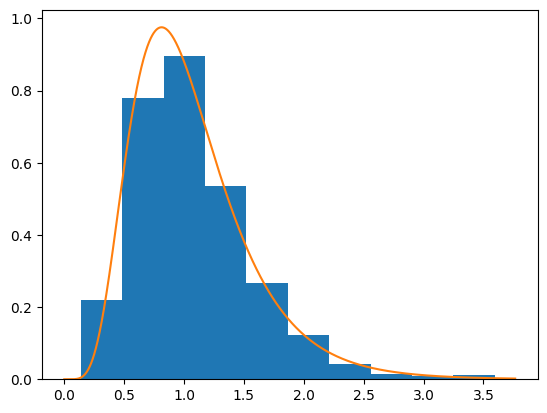

In [ ]:
plt.hist(f1, density = True)
xmin, xmax = plt.xlim()
ox = np.arange(0, xmax, 0.001)
plt.plot(ox, scipy.stats.f.pdf(ox,d1,d2))

In [ ]:
df = table(f1, 'f', df1 = 15, df2 = 30)

print("Критерий пирсона:", sum(df["H"]))
print("Критическое значение:", scipy.stats.chi2.ppf(1-0.05, 12 - 2))

Критерий пирсона: 9.127068752563423
Критическое значение: 18.307038053275146


In [ ]:
df

,left,right,Ni,Wi,Pi,Pn,H,Xi
0,0.140823,0.454626,57,0.057,0.054342,54.342322,0.129977,0.297725
1,0.454626,0.768430,231,0.231,0.246006,246.005881,0.915330,0.611528
2,0.768430,1.082233,297,0.297,0.288711,288.710767,0.237994,0.925331
3,1.082233,1.396036,190,0.190,0.198863,198.863065,0.395015,1.239134
4,1.396036,1.709839,127,0.127,0.108996,108.996105,2.973870,1.552938
5,1.709839,2.023643,51,0.051,0.054006,54.005719,0.167285,1.866741
6,2.023643,2.337446,27,0.027,0.025683,25.683387,0.067494,2.180544
7,2.337446,2.651249,10,0.010,0.012084,12.084001,0.359406,2.494348
8,2.651249,2.965052,4,0.004,0.005716,5.715655,0.514984,2.808151
9,2.965052,3.278856,5,0.005,0.002741,2.741203,1.861287,3.121954


# Стьюдента

In [ ]:
def y_values(k):
    # среднее значение равно нулю и стандартное отклонение равно единице
    z = np.random.normal(size=k)
    return z[0]/np.sqrt(np.sum(z[1:]**2)/k)

k = 9
t1 = np.array([y_values(k) for _ in range(1000)])

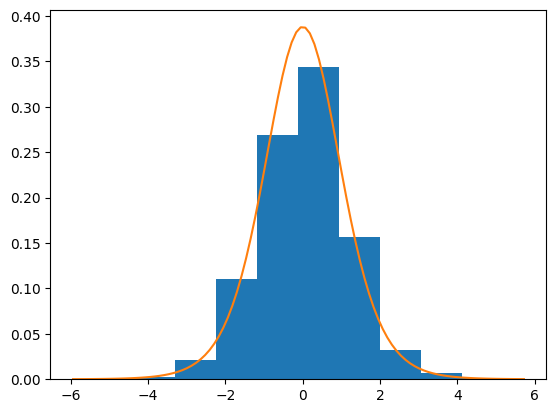

In [ ]:
plt.hist(t1, density = True)
xmin, xmax = plt.xlim()
ox = np.linspace(xmin, xmax, 100)
plt.plot(ox, scipy.stats.t.pdf(ox, k))

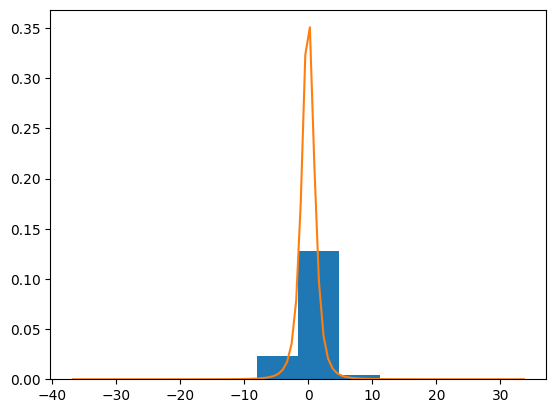

In [ ]:
k = 3
t2 = np.array([y_values(k) for _ in range(1000)])

plt.hist(t2, density = True)
xmin, xmax = plt.xlim()
ox = np.linspace(xmin, xmax, 100)
plt.plot(ox, scipy.stats.t.pdf(ox, k))

In [ ]:
df = table(t1, "t", 9)

print("Критерий пирсона:", sum(df["H"]))
print("Критическое значение:", scipy.stats.chi2.ppf(1-0.05, 12 - 2))

Критерий пирсона: 9.91137008739707
Критическое значение: 18.307038053275146
